In [16]:
import voxelstuff
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import trimesh as tm
import pybullet as p
import pybullet_data as pd
import os
from skimage import measure
import cv2
import scipy
import subprocess
from scipy.interpolate import griddata
from shutil import copyfile

DEBUG = False


refusionBin = "/home/jhm/catkin_ws/src/refusion/bin/"
datasetPath = "/home/jhm/catkin_ws/src/refusion/data"
vhacdPath = "/home/jhm/v-hacd/src/build/test/testVHACD"
outputfile = datasetPath+"/tempVHACD.obj"

CAMRESOLUTION =(640,480)
CAMFOV =(62., 48.6)
#camera intrinsics
cx = 319.5
cy = 239.5
fx = 525.0
fy = 525.0
rows = 480
cols = 640
s=0
K = np.array([[fx,s,cx],
              [0,fy,cy],
              [0,0,1]])
correctionFactor = 5000

comparisonThreshold = 2.5 #meter, difference between expectiation (refusion) and actual depth

####################################################vhacd on mesh

inputfile = datasetPath+"/mesh.obj"
outputfile = datasetPath+"/tempVHACD.obj"

print("Running convex decomposition on the scene")

resolution = 800000 #maximum number of voxels generated during the voxelization stage
depth = 32 #maximum number of clipping stages. During each split stage, all the model parts (with a concavity higher than the user defined threshold) are clipped according the "best" clipping plane 	20 	1-32
concavity =0.003 #maximum concavity 	0.0025 	0.0-1.0
planeDownsampling = 1 #controls the granularity of the search for the "best" clipping plane 	4 	1-16
convexhullDownsampling = 1 #controls the precision of the convex-hull generation process during the clipping plane selection stage 	4 	1-16
alpha = 0.05 #controls the bias toward clipping along symmetry planes 	0.05 	0.0-1.0
beta = 0.05 #controls the bias toward clipping along revolution axes 	0.05 	0.0-1.0
gamma = 0.002 #maximum allowed concavity during the merge stage 	0.00125 	0.0-1.0
pca = 0 #enable/disable normalizing the mesh before applying the convex decomposition 	0 	0-1
mode = 0 #voxel-based approximate convex decomposition, 1: tetrahedron-based approximate convex decomposition 	0 	0-1
maxNumVerticesPerCH = 64 #controls the maximum number of triangles per convex-hull 	64 	4-1024
minVolumePerCH = 0.0001 #controls the adaptive sampling of the generated convex-hulls 	0.0001 	0.0-0.01
subprocess.call("{} --input '{}' --output '{}' --resolution {} --depth {} --concavity {} --planeDownsampling {} --convexhullDownsampling {} --alpha {} --beta {} --gamma {} --pca {} --mode {} --maxNumVerticesPerCH {} --minVolumePerCH {}".format(vhacdPath,
                   inputfile,outputfile,resolution,depth,concavity, planeDownsampling,convexhullDownsampling,alpha,beta,gamma,pca,mode,maxNumVerticesPerCH,minVolumePerCH), shell=True, stdout=subprocess.PIPE)
mesh2 = tm.load(outputfile)
for v in mesh2.vertices:
    v[2] = -v[2]
    v[1] = -v[1]
meshes = mesh2.split()



#randomize the colors to distinct them
nr2color = np.random.random((len(meshes),3))
for i,submesh in enumerate(meshes):
    #submesh.visual.face_colors[:,0] = submesh.visual.face_colors[:,0]//submesh.visual.face_colors[0,0]
    submesh.visual.face_colors[:,0] = np.array([int(nr2color[i][0]*255.)]*len(submesh.visual.face_colors[:,0]))
    #submesh.visual.face_colors[:,1] = submesh.visual.face_colors[:,1]//submesh.visual.face_colors[0,1]
    submesh.visual.face_colors[:,1] = np.array([int(nr2color[i][1]*255.)]*len(submesh.visual.face_colors[:,1]))
    #submesh.visual.face_colors[:,2] = submesh.visual.face_colors[:,2]//submesh.visual.face_colors[0,2]
    submesh.visual.face_colors[:,2] = np.array([int(nr2color[i][2]*255.)]*len(submesh.visual.face_colors[:,2]))

xPlus = tm.Trimesh(vertices=np.array([[0.,0.,0.02],
                                        [0.1,0.,0.],
                                        [0.,0.02,0.],
                                        [0.,-0.02,0.]]), 
                   faces=np.array([[0,1,2],
                                        [1,2,3],
                                        [1,3,0],
                                        [0,2,3]]), face_normals=None, vertex_normals=None, 
                   face_colors=np.array([[0,255,0,255],
                                        [0,255,0,255],
                                        [0,255,0,255],
                                        [0,255,0,255]]), vertex_colors=None, face_attributes=None, vertex_attributes=None, metadata=None, process=True, validate=False, use_embree=True, initial_cache=None, visual=None)
yPlus = tm.Trimesh(vertices=np.array([[0.,0.1,0.0],
                                        [0.02,0.,0.],
                                        [-0.02,0.,0.],
                                        [0.,0.,0.]]), 
                   faces=np.array([[0,1,2],
                                        [1,2,3],
                                        [1,3,0],
                                        [0,2,3]]), face_normals=None, vertex_normals=None, 
                   face_colors=np.array([[255,0,0,255],
                                        [255,0,0,255],
                                        [255,0,0,255],
                                        [255,0,0,255]]), vertex_colors=None, face_attributes=None, vertex_attributes=None, metadata=None, process=True, validate=False, use_embree=True, initial_cache=None, visual=None)
zPlus = tm.Trimesh(vertices=np.array([[0.,0.0,0.1],
                                        [0.0,0.02,0.],
                                        [0.0,-0.02,0.],
                                        [0.02,0.,0.]]), 
                   faces=np.array([[0,1,2],
                                        [1,2,3],
                                        [1,3,0],
                                        [0,2,3]]), face_normals=None, vertex_normals=None, 
                   face_colors=np.array([[0,0,255,255],
                                        [0,0,255,255],
                                        [0,0,255,255],
                                        [0,0,255,255]]), vertex_colors=None, face_attributes=None, vertex_attributes=None, metadata=None, process=True, validate=False, use_embree=True, initial_cache=None, visual=None)



#create associationdict
associations = {}
with open(datasetPath+"/associated.txt","r") as f:
    for line in f.readlines():
        parts = line.split()
        associations[parts[0]] = {"depth":parts[1],"rgb":parts[3],"rgbTime":parts[2]}
with open(datasetPath+"/result.txt","r") as f:
    for line in f.readlines():
        parts = line.split()
        associations[parts[0]]["Camera"] = {"xyz":np.array((float(parts[1]),-float(parts[2]),-float(parts[3]))),
                                           "rot":np.array((float(parts[4]),-float(parts[5]),-float(parts[6]),float(parts[7])))}

#create scene
key = list(associations.keys())[0]
RT = np.concatenate((scipy.spatial.transform.Rotation.from_quat(associations[key]["Camera"]["rot"]).as_matrix(),associations[key]["Camera"]["xyz"][:,None]),axis=-1)
x_rot = 0. /360*np.pi*2.
y_rot = 0. /360*np.pi*2.
z_rot = 0. /360*np.pi*2.
RT_4x4 = np.array([[np.cos(x_rot),-np.sin(x_rot),0,0],
                                        [np.sin(x_rot),np.cos(x_rot),0,0],
                                        [0,0,1,0],
                                        [0,0,0,1]])

RT_4x4 = np.matmul(RT_4x4,np.array([[np.cos(y_rot),0,np.sin(y_rot),0],
                                        [0,1,0,0],
                                        [-np.sin(y_rot),0,np.cos(y_rot),0],
                                        [0,0,0,1]]))

RT_4x4 = np.matmul(RT_4x4,np.array([[1,0,0,0],
                                        [0,np.cos(z_rot),-np.sin(z_rot),0],
                                        [0,np.sin(z_rot),np.cos(z_rot),0],
                                        [0,0,0,1]]))
RT_4x4 = np.matmul(RT_4x4,np.concatenate([RT, np.array([0., 0., 0., 1.])[None, :]], 0))
transform = RT_4x4
camera = tm.scene.Camera(name=None, resolution=CAMRESOLUTION, focal=None, fov=CAMFOV, z_near=0.01, z_far=1000.0)
camera.K = K
scene = tm.scene.scene.Scene(geometry=None, base_frame='world', metadata={}, graph=None, camera=camera, lights=None, camera_transform=transform)
for submesh in meshes:
    scene.add_geometry(submesh)
if DEBUG:
    scene.add_geometry(xPlus)
    scene.add_geometry(yPlus)
    scene.add_geometry(zPlus)

combined = tm.util.concatenate( list(scene.geometry.values())  )
faceIdx2MeshNr = np.stack((np.arange(len(combined.faces),dtype=int),np.ones(len(combined.faces),dtype=int)),1)
processedIdx = 0
for i,mesh_ in enumerate(list(scene.geometry.values())):
    faceIdx2MeshNr[processedIdx:processedIdx+len(mesh_.faces),1] *=i
    processedIdx += len(mesh_.faces)
rayIntersector = tm.ray.ray_pyembree.RayMeshIntersector(combined)

#gehe die einzelpositionen der kameras noch einmal durch und schau, welche gerendert werden.
print("Starting conversion of every Frame")
#fig, ax = plt.subplots()
for ggg,key in enumerate(associations.keys()):
    print("Starting work on frame {} of {}".format(ggg,len(associations.keys())))
    #recreate camera Position
    RT = np.concatenate((scipy.spatial.transform.Rotation.from_quat(associations[key]["Camera"]["rot"]).as_matrix(),associations[key]["Camera"]["xyz"][:,None]),axis=-1)
    x_rot = 0. /360*np.pi*2.
    y_rot = 0. /360*np.pi*2.
    z_rot = 0. /360*np.pi*2.
    RT_4x4 = np.array([[np.cos(x_rot),-np.sin(x_rot),0,0],
                                        [np.sin(x_rot),np.cos(x_rot),0,0],
                                        [0,0,1,0],
                                        [0,0,0,1]])

    RT_4x4 = np.matmul(RT_4x4,np.array([[np.cos(y_rot),0,np.sin(y_rot),0],
                                        [0,1,0,0],
                                        [-np.sin(y_rot),0,np.cos(y_rot),0],
                                        [0,0,0,1]]))

    RT_4x4 = np.matmul(RT_4x4,np.array([[1,0,0,0],
                                        [0,np.cos(z_rot),-np.sin(z_rot),0],
                                        [0,np.sin(z_rot),np.cos(z_rot),0],
                                        [0,0,0,1]]))
    RT_4x4 = np.matmul(RT_4x4,np.concatenate([RT, np.array([0., 0., 0., 1.])[None, :]], 0))
    transform = RT_4x4
    RTIntrinsics3d = np.concatenate((scipy.spatial.transform.Rotation.from_quat(np.array((associations[key]["Camera"]["rot"][0],
                                                                                                -associations[key]["Camera"]["rot"][1],
                                                                                                -associations[key]["Camera"]["rot"][2],
                                                                                                associations[key]["Camera"]["rot"][3]))).as_matrix(),
                                     np.array((associations[key]["Camera"]["xyz"][0],
                                                associations[key]["Camera"]["xyz"][1],
                                                associations[key]["Camera"]["xyz"][2]))[:,None]),axis=-1)
    RT_4x4Intrinsics3d = np.concatenate([RTIntrinsics3d, np.array([0., 0., 0., 1.])[None, :]], 0)
    transformIntrinsics3d = RT_4x4Intrinsics3d
    scene.camera_transform=transform
    #scene.save_image(resolution=None, visible=True)
    #render depth and meshID
    rayDirections, rayXYIdx = scene.camera.to_rays()
    rayDirections = np.matmul(rayDirections,scipy.spatial.transform.Rotation.from_quat(np.array((associations[key]["Camera"]["rot"][0],
                                                                                                associations[key]["Camera"]["rot"][1],
                                                                                                associations[key]["Camera"]["rot"][2],
                                                                                                -associations[key]["Camera"]["rot"][3]))).as_matrix())
    CamLocation = np.array((associations[key]["Camera"]["xyz"][0],
                            associations[key]["Camera"]["xyz"][1],
                            associations[key]["Camera"]["xyz"][2],))
    campos = tm.Trimesh(vertices=np.array([[-0.02,0.02,0.0],
                                        [0.02,-0.02,0.02],
                                        [0.02,0.02,-0.02],
                                        [-0.02,0.,0.02]])+CamLocation, 
                   faces=np.array([[0,1,2],
                                        [1,2,3],
                                        [1,3,0],
                                        [0,2,3]]), face_normals=None, vertex_normals=None, 
                   face_colors=np.array([[150,150,150,255],
                                        [150,150,150,255],
                                        [150,150,150,255],
                                        [150,150,150,255]]), vertex_colors=None, face_attributes=None, vertex_attributes=None, metadata=None, process=True, validate=False, use_embree=True, initial_cache=None, visual=None)
    if ggg%30 == 0:
        if DEBUG:
            scene.add_geometry(campos)
    CamLocation[None,:].repeat(len(rayDirections),0)
    print("    rendering")
    if not DEBUG:
        index_tri,index_ray,locations= rayIntersector.intersects_id(CamLocation[None,:].repeat(len(rayDirections),0), rayDirections, multiple_hits=False, max_hits=1, return_locations=True)
        distances = ((locations-CamLocation[None,:])**2).sum(axis=1)**0.5
        pxIdx = rayXYIdx[index_ray]
        meshIDs = faceIdx2MeshNr[index_tri,1]
        meshIDMask = np.ones(camera.resolution+1,dtype=int)*-1
        zImg = np.zeros(camera.resolution+1)
        print("    filling depth and ImageMask")
        for i in range(len(pxIdx)):
            px = pxIdx[i]
            zImg[px[0],px[1]] = distances[i]
            meshIDMask[px[0],px[1]] = meshIDs[i]
        #compare synthetic depth with camera depth and create a mask
        dImg = cv2.imread(datasetPath+"/"+associations[key]["depth"],-1)

        cv2.imshow("depth",dImg)
        depthComareMask = abs(dImg/correctionFactor-np.rot90(zImg))<comparisonThreshold
        try:
            cv2.imshow("depthComareMask",depthComareMask*1.0)
        except:pass
        refusionMask = cv2.imread(refusionBin+key+".png",-1)

        try:
            cv2.imshow("refusionMask",refusionMask)
        except:pass
        cv2.waitKey(1)
        combinedMask = (refusionMask == 0) # & depthComareMask)
        print("    writing output")
        with open(datasetPath+"/"+'output/{}_mask.png'.format(key), 'wb') as f:
            f.write(combinedMask)
        rotatedIDMask = np.rot90((meshIDMask+1))
        np.save(datasetPath+"/"+'output/{}_ids.pkl'.format(key),rotatedIDMask*combinedMask-1)
        cv2.imwrite(datasetPath+"/"+'output/{}_mask.png'.format(key),combinedMask*255)
        transformStr = ""
        for i in range(16):
            transformStr += str(transformIntrinsics3d.flatten()[i])+" "
            if (i+1)%4 == 0:
                transformStr += "\n"
        with open(datasetPath+"/"+'output/{}.pose.txt'.format(key), 'w') as f:
            f.write(transformStr)
cv2.destroyAllWindows()

Running convex decomposition on the scene
Starting conversion of every Frame
Starting work on frame 0 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 1 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 2 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 3 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 4 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 5 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 6 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 7 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 8 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 9 of 792
    rendering
    

    filling depth and ImageMask
    writing output
Starting work on frame 84 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 85 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 86 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 87 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 88 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 89 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 90 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 91 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 92 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 93 of 792
    rendering
    filling depth an

    filling depth and ImageMask
    writing output
Starting work on frame 167 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 168 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 169 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 170 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 171 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 172 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 173 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 174 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 175 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 176 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 250 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 251 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 252 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 253 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 254 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 255 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 256 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 257 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 258 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 259 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 333 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 334 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 335 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 336 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 337 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 338 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 339 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 340 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 341 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 342 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 416 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 417 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 418 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 419 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 420 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 421 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 422 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 423 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 424 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 425 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 499 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 500 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 501 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 502 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 503 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 504 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 505 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 506 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 507 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 508 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 582 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 583 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 584 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 585 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 586 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 587 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 588 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 589 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 590 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 591 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 665 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 666 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 667 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 668 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 669 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 670 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 671 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 672 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 673 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 674 of 792
    rendering
    fillin

    filling depth and ImageMask
    writing output
Starting work on frame 748 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 749 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 750 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 751 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 752 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 753 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 754 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 755 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 756 of 792
    rendering
    filling depth and ImageMask
    writing output
Starting work on frame 757 of 792
    rendering
    fillin

In [19]:
scene.show()

In [20]:
masks = []
for name in os.listdir(datasetPath+"/output/"):
    if "_ids.pkl.npy" in name:
        masks.append(name)
masks.sort()
print(len(masks))

#nr2color = np.random.random((50,3))
        
#i = 615   
for i in range(len(masks)):
    mask = nr2color[np.load(datasetPath+"/output/"+masks[i])]
    timestamp = masks[i].split("_")[0]
    color = cv2.imread(datasetPath+"/rgb/"+associations[timestamp]["rgbTime"]+".png",-1)/255.
    cv2.imshow("mask",mask*0.5+0.5*color)
    cv2.waitKey(25)
cv2.destroyAllWindows()
#print(masks[i])
#plt.imshow(mask)
#print(mask.max())

792


KeyboardInterrupt: 

In [1]:
import voxelstuff
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import trimesh as tm
import pybullet as p
import pybullet_data as pd
import os
from skimage import measure
import cv2
import scipy
import subprocess
from scipy.interpolate import griddata
from shutil import copyfile

DEBUG = False


refusionBin = "/home/jhm/catkin_ws/src/refusion/bin/"
datasetPath = "/home/jhm/catkin_ws/src/refusion/data"
vhacdPath = "/home/jhm/v-hacd/src/build/test/testVHACD"
outputfile = datasetPath+"/tempVHACD.obj"

CAMRESOLUTION =(640,480)
CAMFOV =(62., 48.6)
#camera intrinsics
cx = 319.5
cy = 239.5
fx = 525.0
fy = 525.0
rows = 480
cols = 640
s=0
K = np.array([[fx,s,cx],
              [0,fy,cy],
              [0,0,1]])
correctionFactor = 5000

comparisonThreshold = 2.5 #meter, difference between expectiation (refusion) and actual depth


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# invert K
#normalize camera (K-1 * uv1)

K_inv = np.linalg.inv(K)

In [5]:
#create associationdict
associations = {}
with open(datasetPath+"/associated.txt","r") as f:
    for line in f.readlines():
        parts = line.split()
        associations[parts[0]] = {"depth":parts[1],"rgb":parts[3],"rgbTime":parts[2]}
with open(datasetPath+"/result.txt","r") as f:
    for line in f.readlines():
        parts = line.split()
        associations[parts[0]]["Camera"] = {"xyz":np.array((float(parts[1]),-float(parts[2]),-float(parts[3]))),
                                           "rot":np.array((float(parts[4]),-float(parts[5]),-float(parts[6]),float(parts[7])))}

In [6]:
timestamp = list(associations.keys())[5]

color = cv2.imread(datasetPath+"/rgb/"+associations[timestamp]["rgbTime"]+".png",-1)/255.
dImg = cv2.imread(datasetPath+"/"+associations[timestamp]["depth"],-1)

WARNING - 2021-11-05 16:29:10,398 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


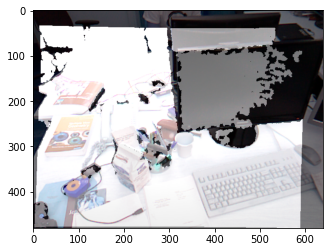

In [7]:
plt.imshow(0.5*color+0.0001*dImg[:,:,None])

In [70]:
import torch
x = torch.arange(dImg.shape[0])[:,None].repeat(1,dImg.shape[1])
y = torch.arange(dImg.shape[1])[None,:].repeat(dImg.shape[0],1)
depthVec = torch.stack([x,y,torch.ones_like(y)],-1)
#depthVec = torch.stack([x,y,torch.tensor(dImg.astype(np.int32)).double()/5000.],-1)
depthVec = depthVec.reshape(-1,3)

In [71]:
depthVec.shape

torch.Size([307200, 3])

In [72]:
K_inv = torch.tensor(K_inv)

<ipython-input-72-5da7b89de959>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_inv = torch.tensor(K_inv)


In [73]:
UV_norm =   depthVec.double()@K_inv

In [74]:
RT = np.concatenate((scipy.spatial.transform.Rotation.from_quat(associations[timestamp]["Camera"]["rot"]).as_matrix(),associations[timestamp]["Camera"]["xyz"][:,None]),axis=-1)
x_rot = 0. /360*np.pi*2.
y_rot = 0. /360*np.pi*2.
z_rot = 0. /360*np.pi*2.
RT_4x4 = np.array([[np.cos(x_rot),-np.sin(x_rot),0,0],
                                        [np.sin(x_rot),np.cos(x_rot),0,0],
                                        [0,0,1,0],
                                        [0,0,0,1]])

RT_4x4 = np.matmul(RT_4x4,np.array([[np.cos(y_rot),0,np.sin(y_rot),0],
                                        [0,1,0,0],
                                        [-np.sin(y_rot),0,np.cos(y_rot),0],
                                        [0,0,0,1]]))

RT_4x4 = np.matmul(RT_4x4,np.array([[1,0,0,0],
                                        [0,np.cos(z_rot),-np.sin(z_rot),0],
                                        [0,np.sin(z_rot),np.cos(z_rot),0],
                                        [0,0,0,1]]))
RT_4x4 = np.matmul(RT_4x4,np.concatenate([RT, np.array([0., 0., 0., 1.])[None, :]], 0))
transform = RT_4x4


In [78]:

points_rotated = torch.cat([UV_norm[:,:2],torch.tensor(dImg.astype(np.int32)).double().reshape(-1,1)/5000.,torch.ones((len(UV_norm),1))],-1)@transform
#points_rotated = torch.cat([UV_norm,torch.ones((len(UV_norm),1))],-1)@transform

In [79]:
import open3d as o3d

array([[0.0745098 , 0.04705882, 0.05490196],
       [0.11764706, 0.04705882, 0.05490196],
       [0.03529412, 0.04705882, 0.0627451 ],
       ...,
       [0.93333333, 0.9254902 , 0.92941176],
       [0.94117647, 0.90588235, 0.94117647],
       [0.94117647, 0.90196078, 0.95686275]])

In [84]:
pointcloudT = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(points_rotated[:,:3]))
colors = color.reshape(-1,3)
#np.ones_like(points_rotated[:,:3]).astype(np.float64)
#colors[:,2] = colors[:,0]*0.
#colors[:,0] = colors[:,1]*0.
pointcloudT.colors = o3d.utility.Vector3dVector(colors)


o3d.visualization.draw_geometries( [pointcloudT])

In [66]:
points_rotated

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.3464e-02,  2.2715e-02, -4.5543e-01,  1.0344e+00],
        [ 2.6927e-02,  4.5430e-02, -9.1086e-01,  1.0689e+00],
        ...,
        [ 1.8094e+01,  2.7769e+01, -5.8116e+02,  4.4943e+01],
        [ 1.8107e+01,  2.7791e+01, -5.8161e+02,  4.4978e+01],
        [ 1.8120e+01,  2.7814e+01, -5.8207e+02,  4.5012e+01]],
       dtype=torch.float64)

In [67]:
transform

array([[ 9.99563037e-01,  1.75561517e-04,  2.95584856e-02,
        -5.29300000e-03],
       [-1.52381110e-03,  9.98958772e-01,  4.55966029e-02,
        -8.07400000e-03],
       [-2.95197035e-02, -4.56217204e-02,  9.98522531e-01,
        -7.55160000e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [69]:
UV_norm

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.9048e-03, -4.5619e-01],
        [ 0.0000e+00,  3.8095e-03, -9.1238e-01],
        ...,
        [ 9.1238e-01,  1.2133e+00, -5.8210e+02],
        [ 9.1238e-01,  1.2152e+00, -5.8256e+02],
        [ 9.1238e-01,  1.2171e+00, -5.8301e+02]], dtype=torch.float64)

In [ ]:
####### USE REALSENSE TUTPRIALS !!!

In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

ModuleNotFoundError: No module named 'pyrealsense2'